# ConvNeXt on FashionMNIST

## Setup

In [1]:
import torch
import torch.nn as nn
import timm
import timm.data
from timm.scheduler.cosine_lr import CosineLRScheduler
import semitorch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange
from itertools import chain
from semitorch import MultiOptimizer, MultiLRScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device = {device}")


def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler._get_values(epoch))
    return lr_per_epoch


convnext_st_classic_atto = timm.create_model(
    "convnext_st_classic_atto",
    in_chans=1,
    patch_size=1,
    num_classes=10,
)
convnext_st_classic_atto = convnext_st_classic_atto.to(device)

convnext_st_maxplusmlp_atto = timm.create_model(
    "convnext_st_maxplusmlp_atto",
    in_chans=1,
    patch_size=1,
    num_classes=10,
)
convnext_st_maxplusmlp_atto = convnext_st_maxplusmlp_atto.to(device)


def num_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)


print(
    f"convnext_st_classic_atto has {num_params(convnext_st_classic_atto):,} parameters"
)
print(
    f"convnext_st_maxplusmlp_atto has {num_params(convnext_st_classic_atto):,} parameters"
)

# print(convnext_st_classic_atto)

# convnext_atto = timm.create_model("convnext_atto", in_chans=1, patch_size=1, num_classes=10)
# convnext_atto = convnext_atto.to(device)
# print(convnext_atto)

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.4
[Taichi] Starting on arch=cuda
device = cuda
convnext_st_classic_atto has 3,375,850 parameters
convnext_st_maxplusmlp_atto has 3,375,850 parameters


In [2]:
model = convnext_st_maxplusmlp_atto

print(len(list(semitorch.maxplus_parameters(model))))
print(len(list(semitorch.nonmaxplus_parameters(model))))
print(len(list(model.parameters())))


24
104
128


In [3]:
# Load FashionMNIST dataset
batch_size = 512
num_workers = 8

transforms_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.286,),(0.353,)),
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.286,),(0.353,)),
    ]
)

trainset = FashionMNIST(root=".", train=True, download=True, transform=transforms_train)
testset = FashionMNIST(root=".", train=False, download=True, transform=transforms_test)

trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)



## Training

We train the network with SGD+momentum under the [one cycle policy](https://arxiv.org/abs/1708.07120).
As usual we use cross entropy loss.
To track the track the training process we plot the accuracy of each training batch as a blue dot, every epoch we also test the network and the training data and plot the network's accuracy as an orange line.

In [4]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y==prediction).sum().item() / float(y.numel())



def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs)/len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = [] # list of accuracy on the test dataset for every epoch
    trainaccs = [] # a list of the accuracies of all the training batches

    fig, ax = plt.subplots(1, 1, figsize=[6,4])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu()==prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            l.backward()
            optimizer.step()
            scheduler.step(epoch)

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(0.75, 1.0)
        ax.plot(np.linspace(0,len(accs),len(trainaccs)), 
            trainaccs, ".", markersize=1.5, markerfacecolor=(0, 0, 1, 0.3))
        ax.plot(np.linspace(1,len(accs),len(accs)), accs)
        ax.text(0.6*epochs, 0.80, f"max test acc = {max(accs):.2%}", ha="center", fontsize=10)
        hdisplay.update(fig)
        
        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)
        

def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()
    model.apply(fn=weight_reset)

In [5]:
convnext_st_classic_atto.reset_parameters()

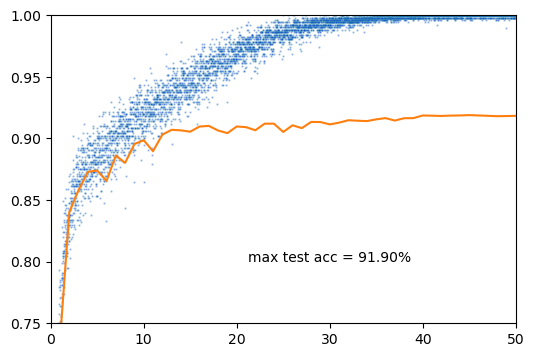

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 50
base_lr = 4e-3

# optimizer = torch.optim.SGD(
#     convnext_st_classic_atto.parameters(), lr=base_lr, momentum=0.9, weight_decay=1e-4
# )
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
#                 max_lr=0.5,
#                 anneal_strategy='linear',
#                 pct_start=0.4,
#                 three_phase=True,
#                 final_div_factor=500.0,
#                 div_factor=25.0,
#                 steps_per_epoch=len(trainloader),
#                 epochs=epochs
#             )


optimizer = torch.optim.AdamW(convnext_st_classic_atto.parameters(), lr=base_lr, weight_decay=5e-3)
scheduler = CosineLRScheduler(
    optimizer,
    t_initial=epochs,
    warmup_t=5,
    warmup_lr_init=base_lr/25,
    lr_min=base_lr/500,
)
# lr_per_epoch = get_lr_per_epoch(scheduler, epochs)
# plt.plot([i for i in range(epochs)], lr_per_epoch, label="With warmup")
# plt.show()

train(
    convnext_st_classic_atto,
    device,
    trainloader,
    testloader,
    optimizer,
    scheduler,
    loss,
    epochs,
)

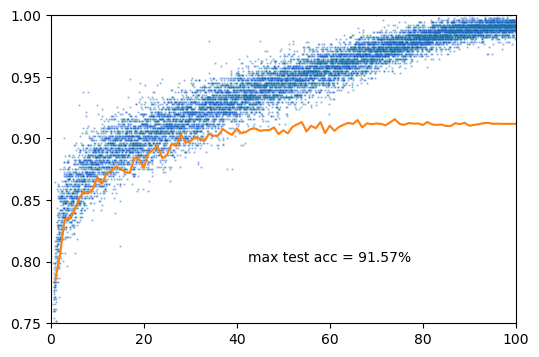

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
model = convnext_st_maxplusmlp_atto
model.reset_parameters()

loss = nn.CrossEntropyLoss(label_smoothing=0.1)
epochs = 100
base_lr = 4e-3

nonmaxplus_params = semitorch.nonmaxplus_parameters(model)
maxplus_params = semitorch.nonmaxplus_parameters(model)

optimizer1 = torch.optim.AdamW(nonmaxplus_params, lr=base_lr, weight_decay=5e-3)
scheduler1 = CosineLRScheduler(
    optimizer1,
    t_initial=epochs,
    warmup_t=5,
    warmup_lr_init=base_lr/25,
    lr_min=base_lr/250,
)

optimizer2 = torch.optim.AdamW(maxplus_params, lr=1e-3, weight_decay=1e-2)
scheduler2 = CosineLRScheduler(
    optimizer2,
    t_initial=epochs,
    warmup_t=5,
    warmup_lr_init=base_lr/50,
    lr_min=base_lr/250,
)

optimizer = MultiOptimizer(optimizer1, optimizer2)
scheduler = MultiLRScheduler(scheduler1, scheduler2)

train(
    model,
    device,
    trainloader,
    testloader,
    optimizer,
    scheduler,
    loss,
    epochs,
)

(array([  329.,    63.,  1446., 15650., 10510.,  2279.,   621.,   136.,
          291.,    35.]),
 array([-4.82909536, -3.55677652, -2.28445792, -1.01213908,  0.26017961,
         1.53249836,  2.8048172 ,  4.07713604,  5.3494544 ,  6.62177324,
         7.89409208]),
 <BarContainer object of 10 artists>)

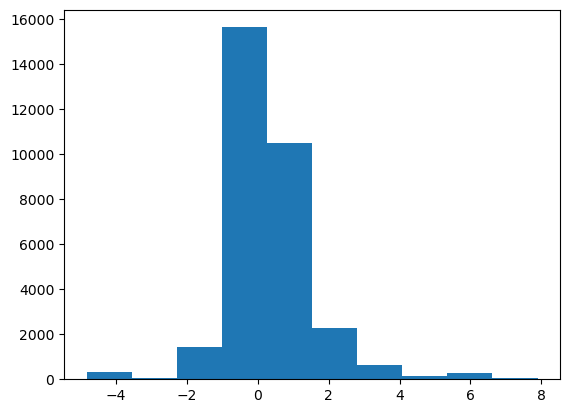

In [6]:
x,y=trainset[0]
z = x.to(device).unsqueeze(0)
z = model.stem(z)
z = model.stages[0].blocks[0].conv_dw(z)
z = model.stages[0].blocks[0].norm(z)
# plt.matshow(x[0])
# plt.matshow(z[0,9].detach().cpu().numpy())
plt.hist(z.detach().reshape(-1).cpu().numpy())

In [14]:
model.stages[0].blocks[0].mlp[0].weight.grad

tensor([[-1.5856e-06, -5.3355e-06,  3.0728e-07,  ...,  1.0621e-05,
          7.5808e-07,  2.7045e-06],
        [-1.1233e-07, -1.6067e-05, -5.2631e-07,  ...,  2.1509e-06,
         -4.8924e-07,  7.4642e-07],
        [ 4.3605e-07, -5.4546e-06,  8.6335e-05,  ...,  1.3348e-05,
          1.0373e-06,  8.2233e-06],
        ...,
        [ 4.2352e-07,  1.4013e-05, -9.4741e-08,  ...,  1.8216e-04,
          4.0627e-07,  3.6899e-06],
        [ 3.1997e-07,  1.4443e-05, -1.8385e-08,  ...,  4.8995e-06,
         -4.5995e-05,  4.1741e-06],
        [ 9.9005e-08,  1.1740e-05,  1.5326e-07,  ...,  2.4256e-06,
          1.0080e-06,  2.2313e-06]], device='cuda:0')

In [10]:
test(model, device, testloader)

0.9119198069852942